NOTE: This is part 2 of analysis.
### Preliminary steps.

In [1]:
# Supress Warnings.

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import important libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [3]:
# Jupyter Notebook will display all rows and columns this way. Use ctrl+/ to comment/un-comment.

from IPython.display import display
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [4]:
# Read csv data.

df = pd.read_csv('df_hr_3.csv', encoding='ascii') # importing dataframe of countries. with one additional ClusterID column.
                                                 # Clustering was done using Hierarchical clustering with 3 clusters.
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 11 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
ClusterID     167 non-null int64
dtypes: float64(7), int64(3), object(1)
memory usage: 14.4+ KB
None


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,2


In [5]:
df2 = df[df['ClusterID']==0] # subset the original dataframe. keep the rows only that belong to cluster 0
df2.shape

(47, 11)

In [6]:
df2.drop('ClusterID', axis=1, inplace=True) # removing the old ClusterID's as we will be clustering this subset df2 again.
df2.shape

(47, 10)

## 1. Modeling.
### 1.a. Standardise features.

In [7]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
col_list = list(df2.columns) # list of all column names.
col_list.remove('country') # remove `country` as it is not a numerical type column.
df_s = df2[col_list]
df_s = standard_scaler.fit_transform(df_s) # s in df_s stands for scaled.

E:\Users\ASHISH\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
E:\Users\ASHISH\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### 1.b. Do PCA.

In [8]:
# Improting the PCA module.

from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=123)

In [9]:
# Doing the PCA on the data.
pca.fit(df_s)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=123,
  svd_solver='randomized', tol=0.0, whiten=False)

### 1.c. Select Principal Components.

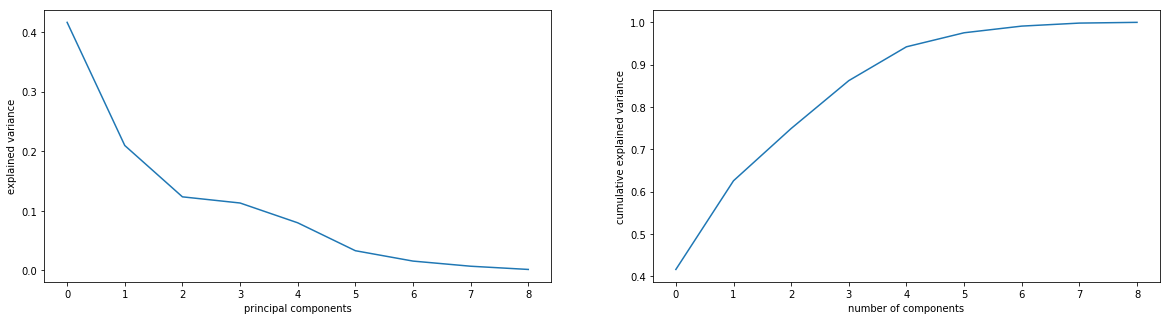

In [10]:
# Making the screeplot - plotting the cumulative variance against the number of components

fig = plt.figure(figsize = (20,5))
ax = plt.subplot(121)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('principal components')
plt.ylabel('explained variance')

ax2 = plt.subplot(122)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.show()

In [11]:
# what percentage of variance in data can be explained by first 3,4 and 5 principal components respectively?
(pca.explained_variance_ratio_[0:3].sum().round(3),
pca.explained_variance_ratio_[0:4].sum().round(3),
pca.explained_variance_ratio_[0:5].sum().round(3))

(0.749, 0.862, 0.942)

Left plot is not of much help as elbow suggests 3 principal components. The right plot suggests to use 4 principal components as the retained variance is 86.2%. This logic of selecting principal components was discussed in previous Jupyter Notebook.

In [12]:
df_pca_tr = pca.transform(df_s) # our data transformed with new features as principal components.
df_pca_tr.round(2)[0:5] # looking at first 5 rows.

array([[-1.25,  0.41,  0.34,  0.15, -0.27,  0.3 ,  0.41,  0.26, -0.07],
       [ 6.1 ,  2.53, -1.56, -0.58, -1.76, -0.63, -0.03, -0.27, -0.16],
       [-0.22, -2.89, -0.18, -0.71,  0.66, -0.12, -0.46, -0.54,  0.02],
       [-1.02,  0.08, -0.03,  0.01, -0.53, -0.62, -0.27, -0.01, -0.07],
       [-1.48,  0.72,  0.31,  0.05, -0.37, -0.25, -0.01, -0.  ,  0.08]])

In [13]:
df_pca4 = df_pca_tr[:,0:4] # since we only require first 4 principal components to explain 86.2% variance.
df_pca4.round(2)[0:5] # look at first 5 rows.

array([[-1.25,  0.41,  0.34,  0.15],
       [ 6.1 ,  2.53, -1.56, -0.58],
       [-0.22, -2.89, -0.18, -0.71],
       [-1.02,  0.08, -0.03,  0.01],
       [-1.48,  0.72,  0.31,  0.05]])

In [14]:
np.corrcoef(df_pca4.T).round(2)

array([[ 1.,  0., -0., -0.],
       [ 0.,  1., -0.,  0.],
       [-0., -0.,  1.,  0.],
       [-0.,  0.,  0.,  1.]])

So it can be seen that PCA has found new components that are not correlated at all. All the diagonal elements are 1, because the same feature is obviously perfectly correlated with itself. But, all the non-diagonal elements are 0. It means no two different features have any correlation.

## 2. Clustering.
### 2.a. Hopkin's Statistic.

In [15]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [16]:
hopkins(pd.DataFrame(df_pca4))

0.7305109676331205

Hopkin's statistic suggests that the data seems clusterable.

### 2.b. K-Means Clustering.

In [17]:
# To perform KMeans clustering 
from sklearn.cluster import KMeans

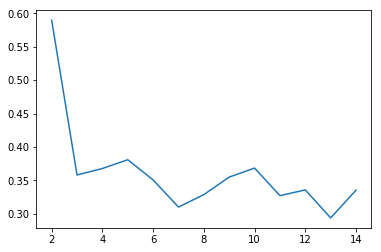

In [18]:
# silhouette scores.

from sklearn.metrics import silhouette_score
def sil_score(df):
    sse_ = []
    for k in range(2, 15):
        kmeans = KMeans(n_clusters=k, random_state=111).fit(df)
        sse_.append([k, silhouette_score(df, kmeans.labels_)])
    plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])

sil_score(df_pca4)

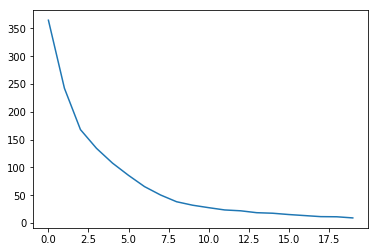

In [19]:
# sum of squared distances

def plot_ssd(df):
    ssd = []
    for num_clusters in list(range(1,21)):
        model_clus = KMeans(n_clusters = num_clusters, max_iter=50, random_state=111)
        model_clus.fit(df)
        ssd.append(model_clus.inertia_)
    plt.plot(ssd)

plot_ssd(df_pca4)

Silhouette score elbow can be seen at k=3. Therefore we select 3 clusters.

In [20]:
# Kmeans with K=3
model_clus3 = KMeans(n_clusters = 3, max_iter=50, random_state=111)
model_clus3.fit(df_pca4)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=111, tol=0.0001, verbose=0)

### 2.c. Analysis of Clusters.

In [21]:
# creation of data frame with original features for analysis of clusters formed.

df_dummy = pd.DataFrame.copy(df2)
df_dummy.reset_index(inplace=True)
df2_hr3 = pd.concat([df_dummy, pd.Series(model_clus3.labels_)], axis=1) # 2 df2_k3 stands for ClusterID 2 of the countries 
                             # of original dataframe provided. k3 stands for 3 clusters on the subset dataframe df2.
df2_hr3.head()

,index,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,0
0,0,Afghanistan,90.2,55.300,41.9174,248.297,1610,9.440,56.2,5.82,553,1
1,3,Angola,119.0,2199.190,100.6050,1514.370,5900,22.400,60.1,6.16,3530,2
2,12,Bangladesh,49.4,121.280,26.6816,165.244,2440,7.140,70.4,2.33,758,0
3,17,Benin,111.0,180.404,31.0780,281.976,1820,0.885,61.8,5.36,758,1
4,25,Burkina Faso,116.0,110.400,38.7550,170.200,1430,6.810,57.9,5.87,575,1


In [22]:
df2_hr3.drop(labels=['index'], axis=1, inplace=True) # label index not required.
df2_hr3.rename(columns={0:'ClusterID'}, inplace=True) # rename the column that contains the Cluster ID's.
df2_hr3.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Afghanistan,90.2,55.300,41.9174,248.297,1610,9.440,56.2,5.82,553,1
1,Angola,119.0,2199.190,100.6050,1514.370,5900,22.400,60.1,6.16,3530,2
2,Bangladesh,49.4,121.280,26.6816,165.244,2440,7.140,70.4,2.33,758,0
3,Benin,111.0,180.404,31.0780,281.976,1820,0.885,61.8,5.36,758,1
4,Burkina Faso,116.0,110.400,38.7550,170.200,1430,6.810,57.9,5.87,575,1


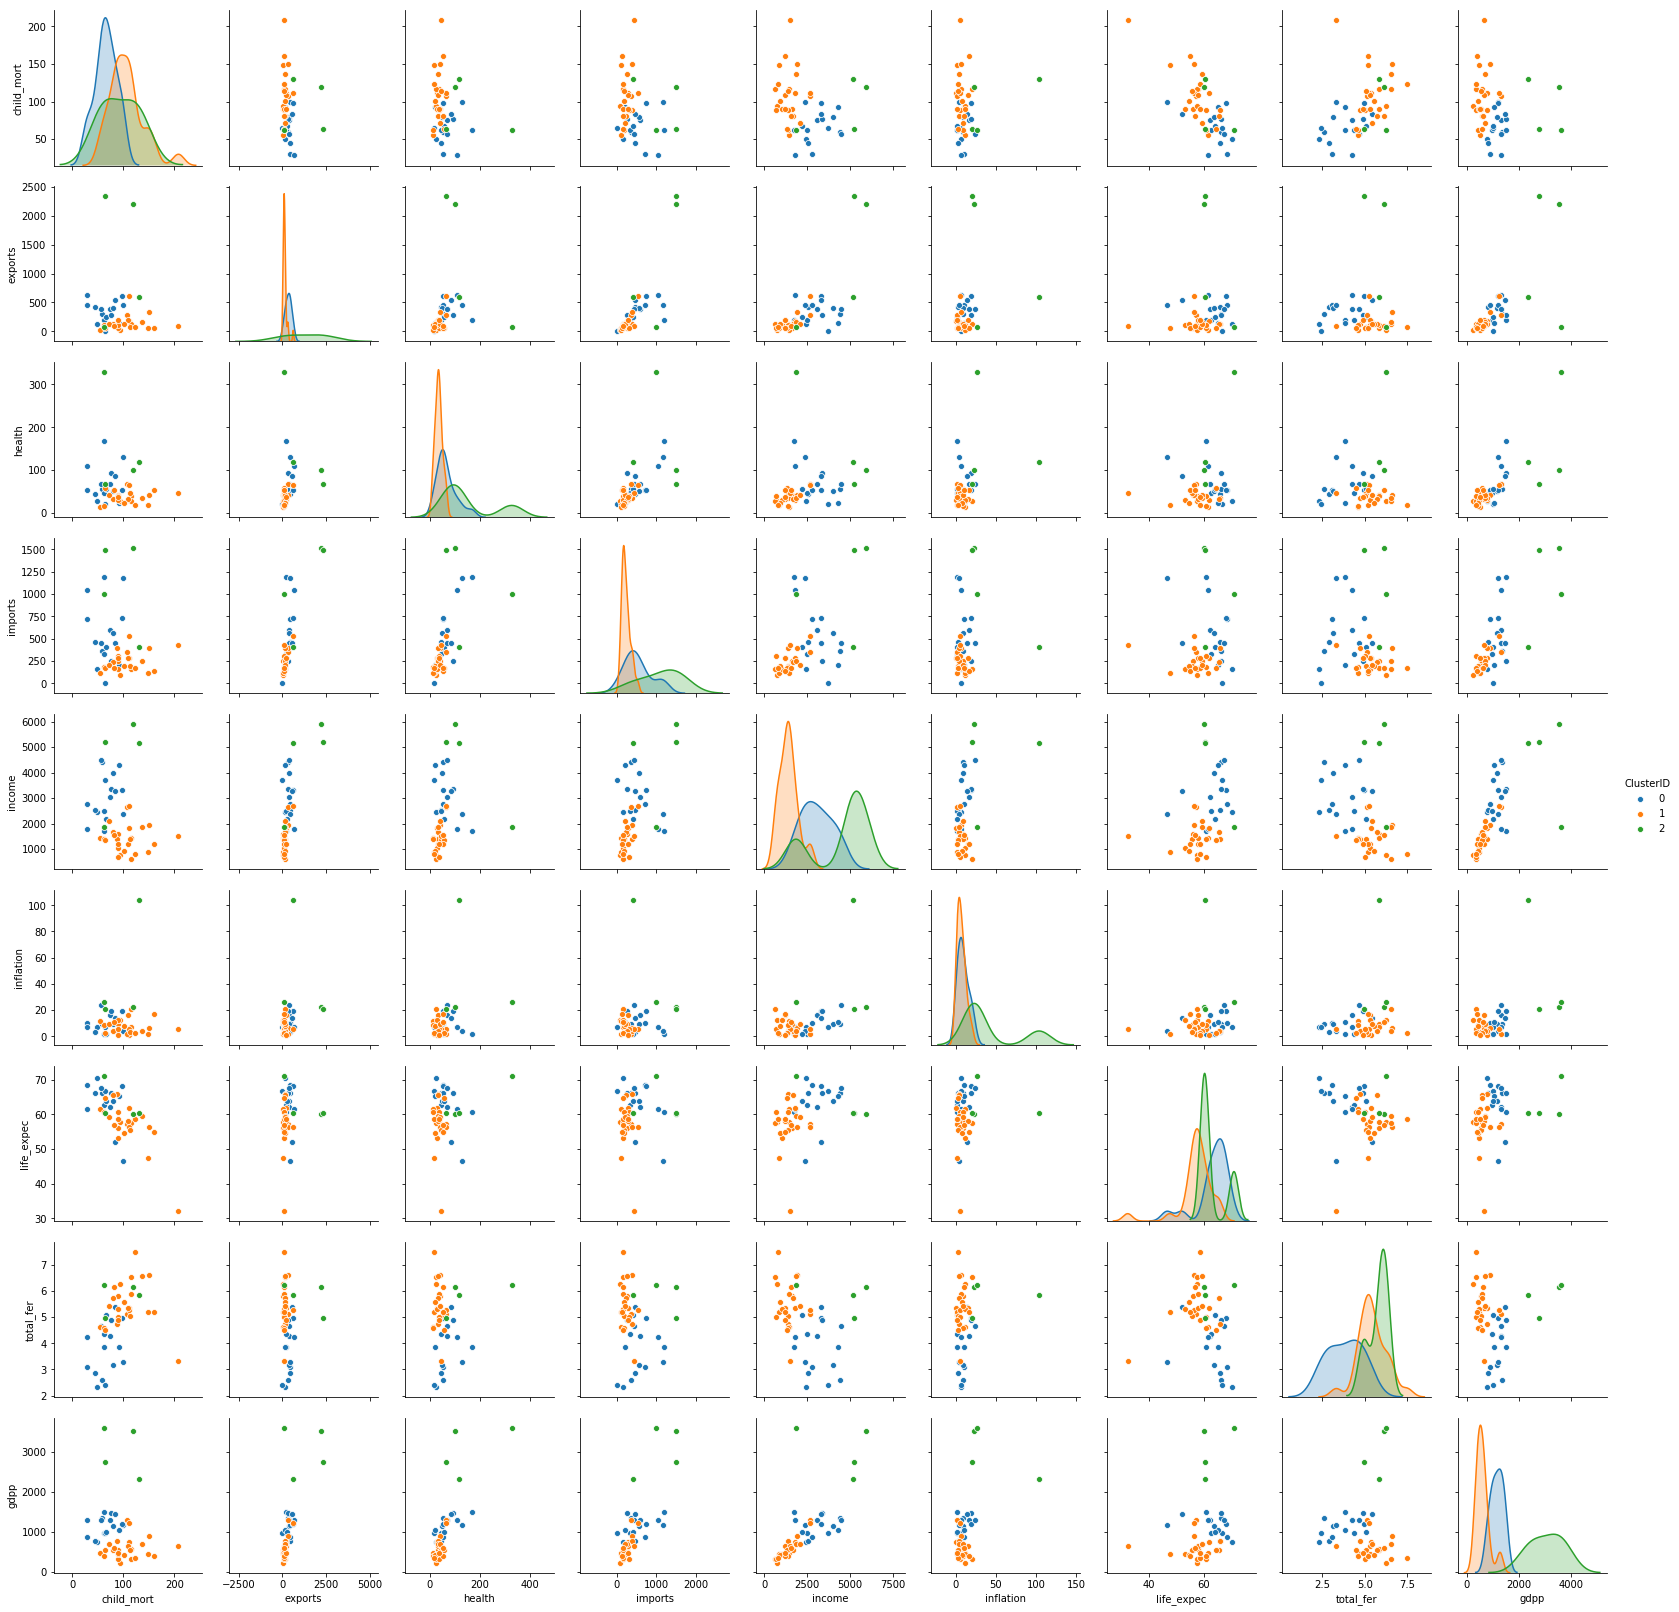

In [23]:
sns.pairplot(data = df2_hr3, vars=col_list, hue='ClusterID') # Get some intuition of how the clustester data points are
                # seperated with respectto original 9 features.

In [24]:
# getting csv files for analysis in tableau. Only addition is the new ClusterID column.

df2_hr3.to_csv('df2_hr3.csv', encoding='utf-8', index=False)

In [25]:
# check for mean and median of all the features.

pd.set_option('display.precision', 2) # Will only show values till 2-decimal places.
grp_hr3 = df2_hr3.groupby('ClusterID')
f={} # empty dictionary.
for col in col_list:
    f[col]=['mean','median'] # creating a dictionary of what functions will be applied on what columns.
grp_hr3 = grp_hr3.agg(f)
grp_hr3 # Note that mean and median are very close for features. This signifies that our clusters are tight, which is good.

child_mort          exports           health          imports  \
                mean  median     mean   median    mean  median     mean   
ClusterID                                                                 
0              66.19   64.40   342.04   386.45   67.85   54.67   536.58   
1             106.51  104.50   140.87   107.53   37.03   36.30   238.92   
2              93.88   91.45  1299.90  1394.34  153.62  109.37  1104.84   

                     income        inflation        life_expec         \
            median     mean median      mean median       mean median   
ClusterID                                                               
0           451.14  3070.59   3060      9.74   8.98      63.47  65.30   
1           198.93  1427.04   1400      7.38   5.93      57.28  57.80   
2          1249.79  4522.50   5170     43.40  24.45      63.02  60.45   

          total_fer            gdpp          
               mean median     mean  median  
ClusterID                                    
0              3.84   3.85  1154.06  1170.0  
1              5.44   5.32   592.88   557.5  
2              5.79   6.00  3050.00  3135.0

Mostly the mean and median values for a cluster and a feature are very close. But their is some gap in gdpp, income and inflation. Nonetheless, let's create a dataframe with median values for plotting in Tableau.

In [26]:
grp_hr3 = df2_hr3.groupby('ClusterID')
median_df2_hr3 = grp_hr3.median()
median_df2_hr3 # median statistic dataframe to be plotted in tablaeu.

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
ClusterID,,,,,,,,,
0,64.40,386.45,54.67,451.14,3060.0,8.98,65.30,3.85,1170.0
1,104.50,107.53,36.30,198.93,1400.0,5.93,57.80,5.32,557.5
2,91.45,1394.34,109.37,1249.79,5170.0,24.45,60.45,6.00,3135.0


In [27]:
median_df2_hr3.reset_index(inplace=True)

In [28]:
# getting csv files for analysis in tableau. Only addition is the new ClusterID column.

median_df2_hr3.to_csv('median_df2_hr3.csv', encoding='utf-8', index=False)

In [29]:
%%HTML
<div class='tableauPlaceholder' id='viz1553205941160' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;SS&#47;SSK2M6G64&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='shared&#47;SSK2M6G64' /> <param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;SS&#47;SSK2M6G64&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1553205941160');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1000px';vizElement.style.height='827px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

How many countries belong to each cluster?

In [30]:
df2_hr3['ClusterID'].value_counts()

1    26
0    17
2     4
Name: ClusterID, dtype: int64

<font size=9>Conclusion 2.</font>

All the 26 countries belonging to ClusterID 1 that require most attention and has the poorest socio-economic conditions.

In [31]:
df2_hr3[df2_hr3['ClusterID']==1]['country'].unique()

array(['Afghanistan', 'Benin', 'Burkina Faso', 'Burundi', 'Cameroon',
       'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.',
       "Cote d'Ivoire", 'Eritrea', 'Gambia', 'Guinea', 'Guinea-Bissau',
       'Haiti', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mozambique',
       'Niger', 'Rwanda', 'Sierra Leone', 'Tanzania', 'Togo', 'Uganda'],
      dtype=object)